
# Analysis of Synthetic CIFAR-10 Cats vs. Original CIFAR-10 Cats

This notebook compares your synthetic CIFAR‑10 cat images (located in
`/home/ubuntu/KarolMgr/sd-imbalance/notebooks/blurry_LoRA_full_prompt`) with the original CIFAR‑10 “cat” images from torchvision.

We will:
- Load and inspect both datasets.
- Compute per-channel statistics (mean, standard deviation) and overall brightness.
- Plot histograms of pixel values and channel means.
- Use PCA to visualize the distribution of images in a lower-dimensional space.
- Display a few sample images.

All plots are created with Plotly for interactive exploration.


In [126]:
# %%
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
# For PCA
from sklearn.decomposition import PCA

# PyTorch & torchvision for the original dataset
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms


# Set Plotly renderer (you can change this if needed)
import plotly.io as pio
pio.renderers.default = "notebook"

# For reproducibility
np.random.seed(42)




## Load Original CIFAR-10 Cat Images

We download (if necessary) the CIFAR-10 training set using torchvision. Since CIFAR-10
has 10 classes, we filter only the “cat” images. (In CIFAR-10, the `"cat"` label is mapped to `3`.)


In [127]:
# Define a transform to convert images to tensors in [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to Tensor (C x H x W) in [0,1]
])

# Download and load the training set
cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# Get the label for 'cat'
cat_label = cifar10_dataset.class_to_idx['cat']  # should be 3

# Filter out only cat images
original_cat_images = [img for img, label in cifar10_dataset if label == cat_label]

print(f"Number of original CIFAR-10 cat images: {len(original_cat_images)}")

Number of original CIFAR-10 cat images: 5000


In [128]:
# Path to your synthetic images (update if necessary)
synthetic_path = "/home/karol/sd-imbalance/flux_tests"

# List all image files (png, jpg, jpeg)
synthetic_image_files = glob.glob(os.path.join(synthetic_path, '*.png')) + \
                        glob.glob(os.path.join(synthetic_path, '*.jpg')) + \
                        glob.glob(os.path.join(synthetic_path, '*.jpeg'))

# Load images using PIL
synthetic_cat_images = []
for img_file in synthetic_image_files:
    try:
        img = Image.open(img_file).convert("RGB")
        synthetic_cat_images.append(img)
    except Exception as e:
        print(f"Error loading {img_file}: {e}")

print(f"Number of synthetic cat images: {len(synthetic_cat_images)}")

Number of synthetic cat images: 1173


In [129]:
def convert_tensor_to_array(img_tensor):
    """
    Convert a PyTorch tensor (C x H x W) to a NumPy array (H x W x C).
    Assumes the tensor is in [0, 1].
    """
    return img_tensor.permute(1, 2, 0).numpy()

def ensure_array(img, source="pil"):
    """
    Given an image either as a PIL image or as a PyTorch tensor,
    return a NumPy array of shape (H, W, C) with values in [0, 1] (if applicable).
    """
    if source == "pil":
        # Convert PIL image to numpy array and scale to [0, 1]
        arr = np.array(img).astype(np.float32) / 255.0
        # If the image is grayscale, replicate channels
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
    elif source == "tensor":
        arr = convert_tensor_to_array(img)
    elif source == "numpy":
        arr = img
    else:
        raise ValueError("Unknown source type.")
    return arr

def compute_image_statistics(img_array):
    """
    Compute per-channel mean and standard deviation for a single image array.
    """
    mean = img_array.mean(axis=(0, 1))
    std = img_array.std(axis=(0, 1))
    brightness = img_array.mean()  # average brightness over all channels
    return mean, std, brightness

def aggregate_dataset_stats(image_list, source="pil"):
    """
    Compute aggregated statistics for a list of images.
    Returns:
      - avg_channel_mean: Mean of means over images (per channel)
      - avg_channel_std: Mean of std dev over images (per channel)
      - brightnesses: List of overall brightness per image
    """
    channel_means = []
    channel_stds = []
    brightnesses = []
    
    for img in image_list:
        arr = ensure_array(img, source=source)
        mean, std, brightness = compute_image_statistics(arr)
        channel_means.append(mean)
        channel_stds.append(std)
        brightnesses.append(brightness)
    
    channel_means = np.array(channel_means)
    channel_stds = np.array(channel_stds)
    avg_channel_mean = channel_means.mean(axis=0)
    avg_channel_std = channel_stds.mean(axis=0)
    
    return avg_channel_mean, avg_channel_std, brightnesses

def images_to_flat_array(image_list, source="pil"):
    """
    Convert a list of images into a 2D array where each row is a flattened image.
    """
    arr_list = []
    for img in image_list:
        arr = ensure_array(img, source=source)
        arr_list.append(arr.flatten())
    return np.array(arr_list)

## Compute and Compare Statistics

We calculate:
- Channel-wise average mean and standard deviation.
- Distribution of overall brightness.
- And then visualize these with Plotly.

In [130]:
# Original CIFAR-10 cat images (source: tensor)
orig_avg_mean, orig_avg_std, orig_brightness = aggregate_dataset_stats(original_cat_images, source="tensor")
print("Original CIFAR-10 cat images:")
print(f"  Average per-channel mean: {orig_avg_mean}")
print(f"  Average per-channel std:  {orig_avg_std}")
print(f"  Overall brightness (first 5 values): {np.array(orig_brightness)[:5]}")

# Synthetic images (source: pil)
synth_avg_mean, synth_avg_std, synth_brightness = aggregate_dataset_stats(synthetic_cat_images, source="pil")
print("\nSynthetic cat images:")
print(f"  Average per-channel mean: {synth_avg_mean}")
print(f"  Average per-channel std:  {synth_avg_std}")
print(f"  Overall brightness (first 5 values): {np.array(synth_brightness)[:5]}")

Original CIFAR-10 cat images:
  Average per-channel mean: [0.4954817  0.45641166 0.41553804]
  Average per-channel std:  [0.21029162 0.2073054  0.20723984]
  Overall brightness (first 5 values): [0.2764655  0.34873366 0.40780744 0.32810077 0.47184053]

Synthetic cat images:
  Average per-channel mean: [0.48973158 0.42398643 0.3451156 ]
  Average per-channel std:  [0.207942   0.20131826 0.19892538]
  Overall brightness (first 5 values): [0.40430692 0.70464784 0.3270098  0.50126344 0.40991497]


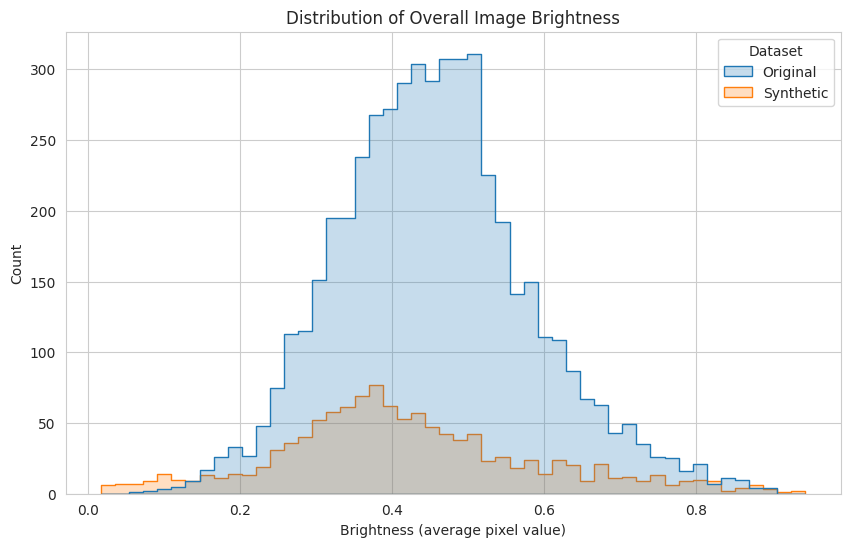

In [131]:
df_brightness = pd.DataFrame({
    "Brightness": np.concatenate([orig_brightness, synth_brightness]),
    "Dataset": ["Original"] * len(orig_brightness) + ["Synthetic"] * len(synth_brightness)
})

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_brightness, x="Brightness", hue="Dataset", element="step", stat="count", bins=50, common_norm=False)

# Add titles and labels
plt.title("Distribution of Overall Image Brightness")
plt.xlabel("Brightness (average pixel value)")
plt.ylabel("Count")

# Show the plot
plt.show()

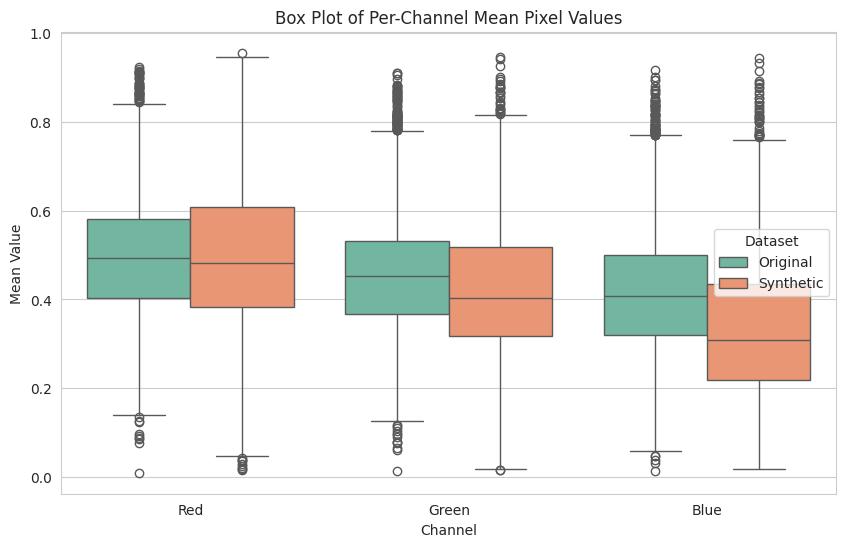

In [132]:
def create_channel_df(image_list, source="pil"):
    channels = ['Red', 'Green', 'Blue']
    data = {ch: [] for ch in channels}
    for img in image_list:
        arr = ensure_array(img, source=source)
        # Compute channel means
        means = arr.mean(axis=(0,1))
        for i, ch in enumerate(channels):
            data[ch].append(means[i])
    return pd.DataFrame(data)

df_orig = create_channel_df(original_cat_images, source="tensor")
df_orig["Dataset"] = "Original"

df_synth = create_channel_df(synthetic_cat_images, source="pil")
df_synth["Dataset"] = "Synthetic"

df_channels = pd.concat([df_orig, df_synth], ignore_index=True)
df_channels = pd.melt(df_channels, id_vars="Dataset", value_vars=['Red', 'Green', 'Blue'], 
                      var_name="Channel", value_name="Mean Value")

sns.set_style("whitegrid")

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_channels, x="Channel", y="Mean Value", hue="Dataset", palette="Set2")

# Add titles and labels
plt.title("Box Plot of Per-Channel Mean Pixel Values")
plt.xlabel("Channel")
plt.ylabel("Mean Value")

# Display the plot
plt.show()

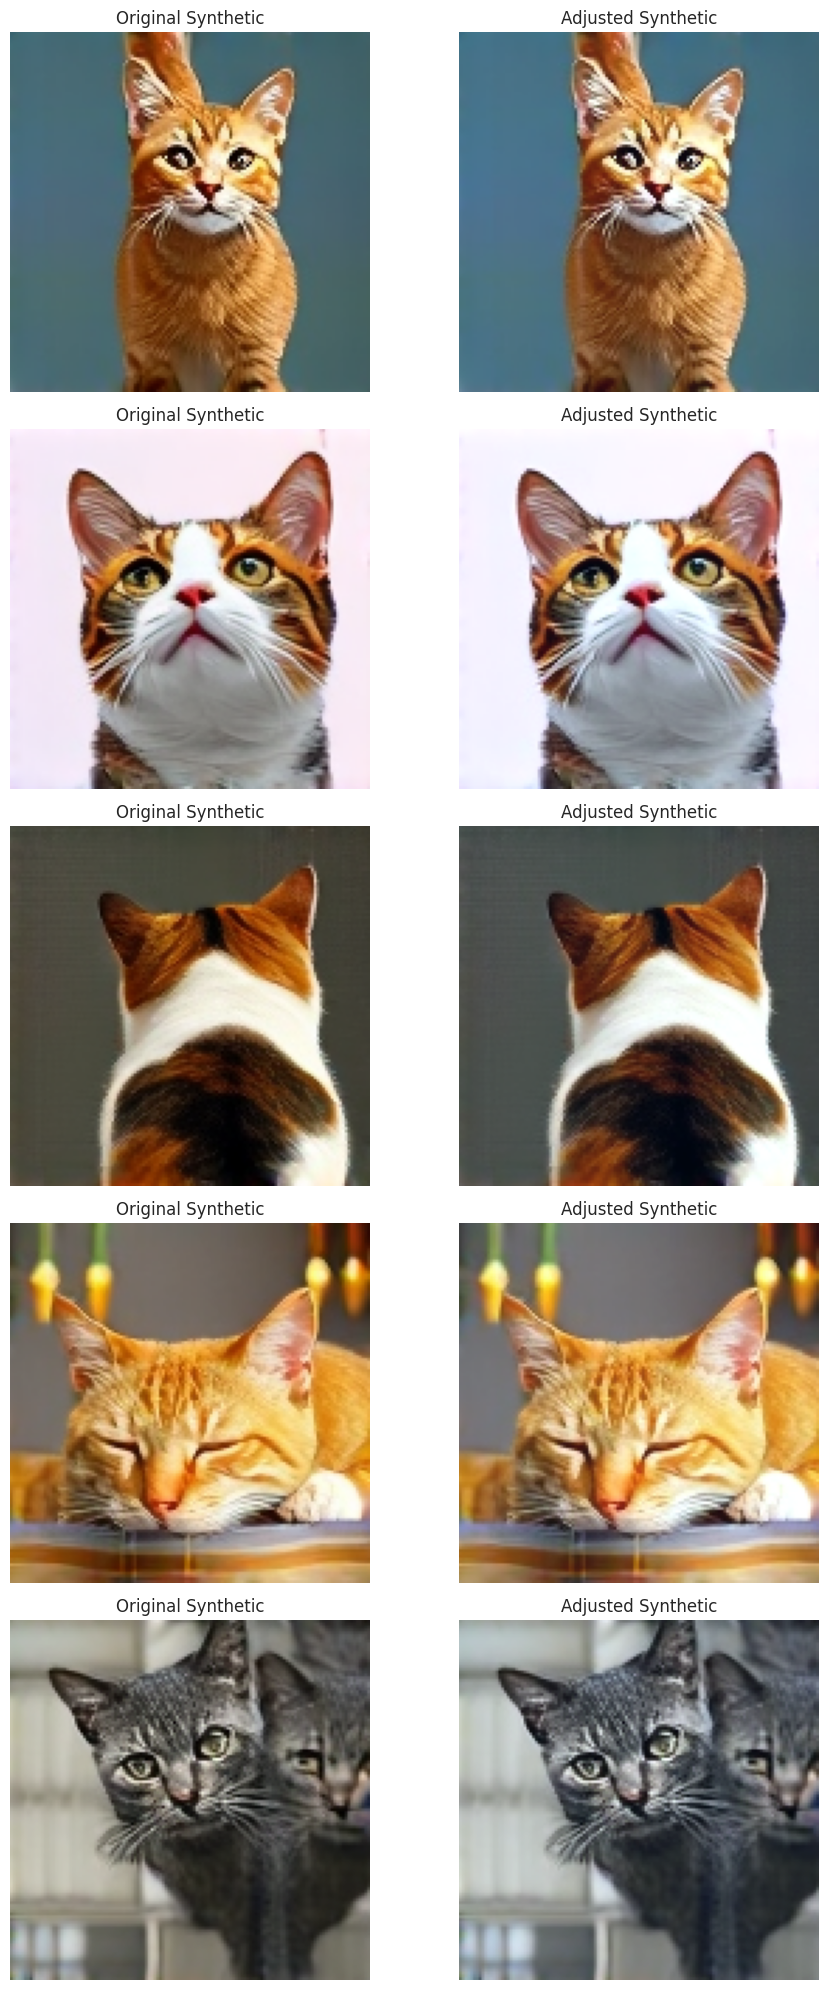

Original CIFAR-10 cat images:
  Average per-channel mean: [0.4954817  0.45641166 0.41553804]
  Average per-channel std:  [0.21029162 0.2073054  0.20723984]
  Overall brightness (first 5 values): [0.2764655  0.34873366 0.40780744 0.32810077 0.47184053]

Synthetic cat images:
  Average per-channel mean: [0.49344069 0.45364695 0.41144367]
  Average per-channel std:  [0.20997224 0.20629031 0.20502157]
  Overall brightness (first 5 values): [0.43836814 0.73739572 0.3579897  0.53664008 0.4444032 ]


In [133]:
import numpy as np
from PIL import Image

def adjust_images(synthetic_images, orig_mean, orig_std, synth_mean, synth_std):
    """Apply histogram matching to synthetic images using mean-std adjustment."""
    synthetic_images = np.array(synthetic_images, dtype=np.float32)  # Ensure float format
    
    if synthetic_images.max() > 1.1:
        synthetic_images /= 255.0  # Normalize if needed

    adjusted_images = (synthetic_images - synth_mean[None, None, None, :]) / synth_std[None, None, None, :]
    adjusted_images = adjusted_images * orig_std[None, None, None, :] + orig_mean[None, None, None, :]

    adjusted_images = np.clip(adjusted_images * 255, 0, 255).astype(np.uint8)

    return adjusted_images

adjusted_synthetic_images = adjust_images(synthetic_cat_images, orig_avg_mean, orig_avg_std, synth_avg_mean, synth_avg_std)

np_to_pil = lambda x: Image.fromarray(x)

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    axes[i, 0].imshow(synthetic_cat_images[i])
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Original Synthetic")
    axes[i, 1].imshow(np_to_pil(adjusted_synthetic_images[i]))
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Adjusted Synthetic")
plt.tight_layout()
plt.show()

orig_avg_mean, orig_avg_std, orig_brightness = aggregate_dataset_stats(original_cat_images, source="tensor")
print("Original CIFAR-10 cat images:")
print(f"  Average per-channel mean: {orig_avg_mean}")
print(f"  Average per-channel std:  {orig_avg_std}")
print(f"  Overall brightness (first 5 values): {np.array(orig_brightness)[:5]}")

# Synthetic images (source: pil)
synth_avg_mean, synth_avg_std, synth_brightness = aggregate_dataset_stats(adjusted_synthetic_images, source="numpy")
print("\nSynthetic cat images:")
print(f"  Average per-channel mean: {synth_avg_mean/255}")
print(f"  Average per-channel std:  {synth_avg_std/255}")
print(f"  Overall brightness (first 5 values): {np.array(synth_brightness)[:5]/255}")

### PCA on Image Data

We flatten each image into a vector and run PCA (reducing to 2 dimensions) to see if
the two datasets have a similar distribution in the high-dimensional pixel space.

Number of original samples: 5000
Number of synthetic samples: 1173
Number of adjusted synthetic samples: 1173
Shape of first original sample: torch.Size([3, 32, 32])
Shape of first synthetic sample: (128, 128)
Shape of first adjusted synthetic sample: (128, 128, 3)
Original flattened shape: (5000, 3072)
Synthetic flattened shape: (1173, 3072)
Adjusted synthetic flattened shape: (1173, 3072)
Explained variance ratio by PCA components: [0.7883858  0.04378886]


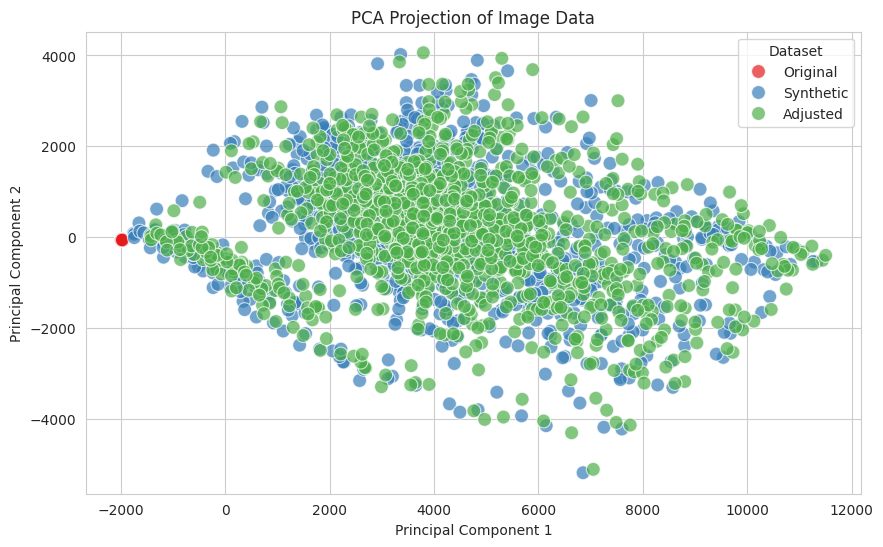

In [136]:
# Limit to a subset of images (for speed) if needed
n_samples = 5000  # adjust based on available memory and speed
orig_samples = original_cat_images[:min(n_samples, len(original_cat_images))]
print(f"Number of original samples: {len(orig_samples)}")
synth_samples = synthetic_cat_images[:min(n_samples, len(synthetic_cat_images))]
print(f"Number of synthetic samples: {len(synth_samples)}")
adj_samples = adjusted_synthetic_images[:min(n_samples, len(adjusted_synthetic_images))]
print(f"Number of adjusted synthetic samples: {len(adj_samples)}")

# Print shape information for debugging
print(f"Shape of first original sample: {orig_samples[0].shape if hasattr(orig_samples[0], 'shape') else 'Not a tensor'}")
print(f"Shape of first synthetic sample: {synth_samples[0].size if hasattr(synth_samples[0], 'size') else 'Not a PIL image'}")
print(f"Shape of first adjusted synthetic sample: {adj_samples[0].shape if hasattr(adj_samples[0], 'shape') else 'Not a tensor'}")

# Flatten images - ensure consistent dimensions
# CIFAR-10 images are 32x32x3 (3072 flattened)
# Make sure synthetic images are also resized to 32x32 before flattening
def resize_and_flatten(images, source="pil", target_size=(32, 32)):
    if source == "pil":
        # Resize PIL images and convert to numpy arrays
        resized = [img.resize(target_size) for img in images]
        return np.array([np.array(img).flatten() for img in resized])
    elif source == "tensor":
        # For tensors, ensure they're the right size then flatten
        return np.array([img.numpy().flatten() for img in images])
    elif source == "numpy":
        # For numpy arrays, resize if needed then flatten
        resized = [img if img.shape[:2] == target_size else np.array(Image.fromarray(img).resize(target_size)) for img in images]
        return np.array([img.flatten() for img in resized])
    else:
        raise ValueError(f"Unknown source: {source}")

# Use the new function
orig_flat = resize_and_flatten(orig_samples, source="tensor", target_size=(32, 32))
synth_flat = resize_and_flatten(synth_samples, source="pil", target_size=(32, 32))
adj_flat = resize_and_flatten(adj_samples, source="numpy", target_size=(32, 32))

# Verify shapes
print(f"Original flattened shape: {orig_flat.shape}")
print(f"Synthetic flattened shape: {synth_flat.shape}")
print(f"Adjusted synthetic flattened shape: {adj_flat.shape}")

# Now ensure both have the same number of features before concatenating
min_features = min(orig_flat.shape[1], synth_flat.shape[1])
orig_flat = orig_flat[:, :min_features]
synth_flat = synth_flat[:, :min_features]
adj_flat = adj_flat[:, :min_features]

# Combine the data and create labels
X = np.concatenate([orig_flat, synth_flat, adj_flat], axis=0)
labels = ["Original"] * orig_flat.shape[0] + ["Synthetic"] * synth_flat.shape[0] + ["Adjusted"] * adj_flat.shape[0]

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)

# Create a DataFrame for visualization
df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Dataset": labels
})

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(
    data=df_pca,
    x="PC1", y="PC2",
    hue="Dataset",
    palette="Set1",
    s=100,  # Adjust the size of the points
    alpha=0.7  # Adjust the transparency of the points
)

# Add titles and labels
plt.title("PCA Projection of Image Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add a legend
plt.legend(title='Dataset')

# Show the plot
plt.show()

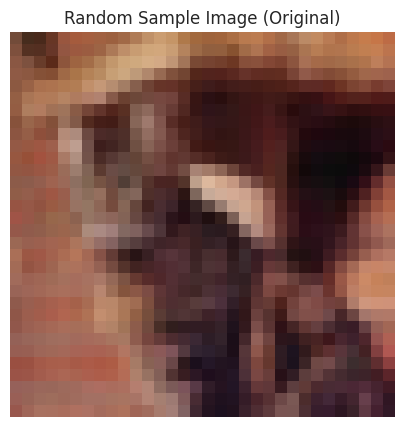

In [137]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_image(image_list, source="pil"):
    """Randomly select one image from the image_list and convert it to an array."""
    img = random.choice(image_list)
    return ensure_array(img, source=source)

# Select one random image from each dataset
sample_orig = get_random_image(original_cat_images, source="tensor")

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow((sample_orig * 255).astype(np.uint8))  # Change to `sample_synth` for a synthetic image
plt.title("Random Sample Image (Original)")  # Change to "Synthetic" if using sample_synth
plt.axis("off")  # Hide axis ticks
plt.show()


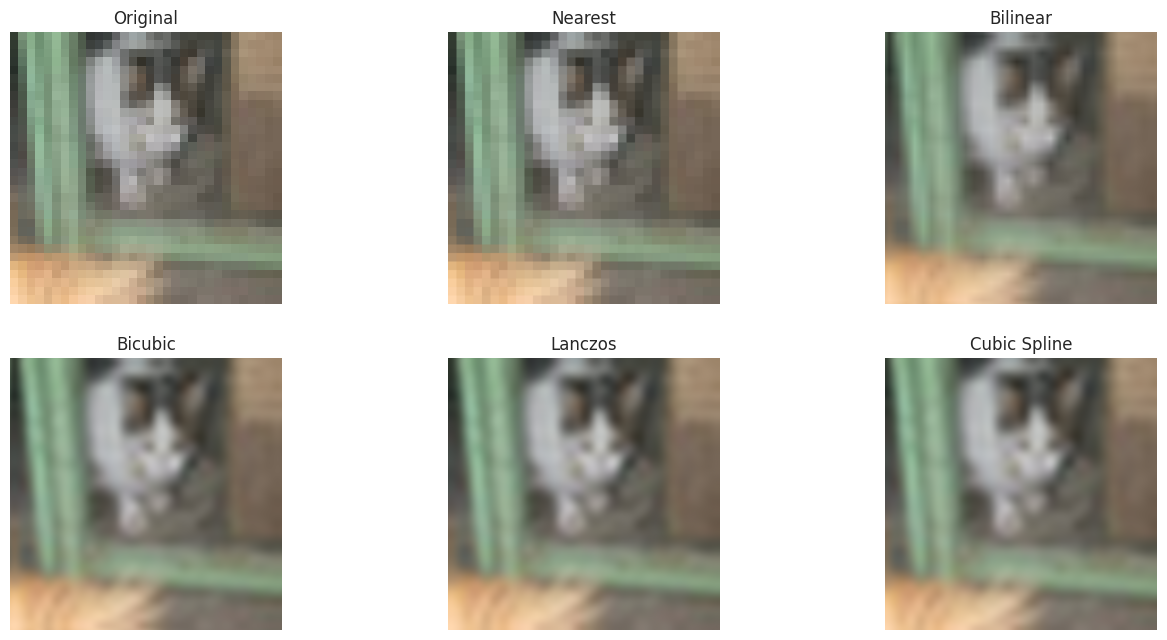

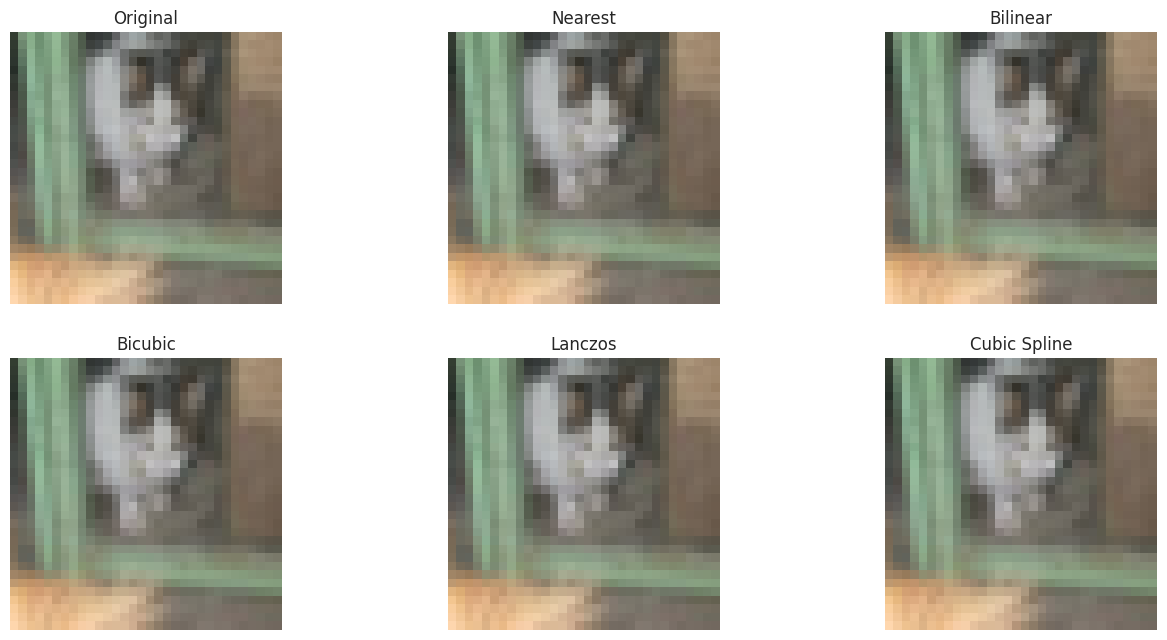

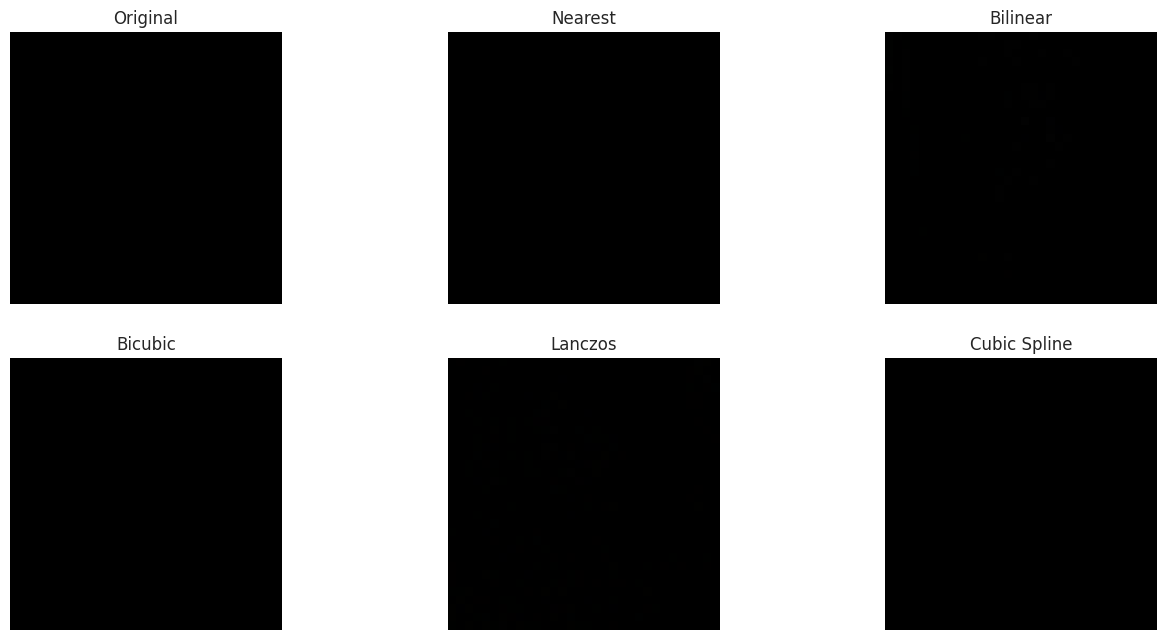

Differences:
Original: Max difference = 0.0000, Mean difference = 0.0000
Nearest: Max difference = 0.0000, Mean difference = 0.0000
Bilinear: Max difference = 0.0105, Mean difference = 0.0015
Bicubic: Max difference = 0.0001, Mean difference = 0.0000
Lanczos: Max difference = 0.0039, Mean difference = 0.0004
Cubic Spline: Max difference = 0.0000, Mean difference = 0.0000


In [120]:
import numpy as np
import cv2
from skimage.transform import resize
from scipy.ndimage import zoom
from PIL import Image

# Ensure sample_orig is in the right format (assuming it's a numpy array with values between 0 and 1)
sample_uint8 = (sample_orig * 255).astype(np.uint8)

# Target size for upscaling
target_size = (512, 512)
downsample_size = (32, 32)

# Method 1: Nearest Neighbor
nearest = resize(sample_orig, target_size, order=0, anti_aliasing=False)
down_nearest = resize(nearest, downsample_size, order=0, anti_aliasing=False)

# Method 2: Bilinear
bilinear = resize(sample_orig, target_size, order=1, anti_aliasing=False)
down_bilinear = resize(bilinear, downsample_size, order=1, anti_aliasing=False)

# Method 3: Bicubic
bicubic = resize(sample_orig, target_size, order=3, anti_aliasing=False)
down_bicubic = resize(bicubic, downsample_size, order=3, anti_aliasing=False)

# Method 4: Lanczos (OpenCV)
if len(sample_uint8.shape) == 3:
    lanczos = cv2.resize(sample_uint8, target_size, interpolation=cv2.INTER_LANCZOS4)
    lanczos = lanczos.astype(float) / 255.0
    
    # Downsample using the same Lanczos algorithm
    down_lanczos = cv2.resize(
        (lanczos * 255).astype(np.uint8), 
        downsample_size, 
        interpolation=cv2.INTER_LANCZOS4
    ).astype(float) / 255.0
else:
    lanczos = cv2.resize(sample_uint8, target_size, interpolation=cv2.INTER_LANCZOS4)
    lanczos = lanczos.astype(float) / 255.0
    
    # Downsample using the same Lanczos algorithm
    down_lanczos = cv2.resize(
        (lanczos * 255).astype(np.uint8), 
        downsample_size, 
        interpolation=cv2.INTER_LANCZOS4
    ).astype(float) / 255.0

# Method 5: Cubic spline (SciPy)
zoom_factors = [target_size[0]/sample_orig.shape[0], target_size[1]/sample_orig.shape[1]]
if len(sample_orig.shape) == 3:
    zoom_factors.append(1)
spline = zoom(sample_orig, zoom_factors, order=3)

# Downsample using the same cubic spline algorithm
down_zoom_factors = [downsample_size[0]/spline.shape[0], downsample_size[1]/spline.shape[1]]
if len(spline.shape) == 3:
    down_zoom_factors.append(1)
down_spline = zoom(spline, down_zoom_factors, order=3)

# Also downsample original with nearest neighbor for comparison
down_orig = resize(sample_orig, downsample_size, order=0, anti_aliasing=False)

# List of all images
images = [sample_orig, nearest, bilinear, bicubic, lanczos, spline]
titles = ['Original', 'Nearest', 'Bilinear', 'Bicubic', 'Lanczos', 'Cubic Spline']
downsampled = [down_orig, down_nearest, down_bilinear, down_bicubic, down_lanczos, down_spline]

downsampled_minus_orig = [np.abs(down - down_orig) for down in downsampled]

# Display the images
plt.figure(figsize=(16, 12))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.show()

# Display the downsampled images
plt.figure(figsize=(16, 12))
for i, (img, title) in enumerate(zip(downsampled, titles)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.show()

# Display the difference between downsampled and original images
plt.figure(figsize=(16, 12))
for i, (img, title) in enumerate(zip(downsampled_minus_orig, titles)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.show()

print("Differences:")
for title, diff in zip(titles, downsampled_minus_orig):
    print(f"{title}: Max difference = {diff.max():.4f}, Mean difference = {diff.mean():.4f}")

         Method       MSE       PSNR      SSIM       MAE  Correlation  \
0       Nearest  0.000341  34.676671  0.987473  0.012021     0.997837   
1      Bilinear  0.000594  32.258789  0.978241  0.016155     0.996233   
2       Bicubic  0.000270  35.692514  0.990355  0.010876     0.998282   
3       Lanczos  0.000240  36.201661  0.991332  0.010049     0.998460   
4  Cubic Spline  0.000804  30.947209  0.975669  0.018910     0.994963   

   Mean Diff  Std Diff  
0   0.000415  0.005658  
1   0.001799  0.007633  
2   0.001871  0.004530  
3   0.000036  0.004420  
4   0.002756  0.009197  


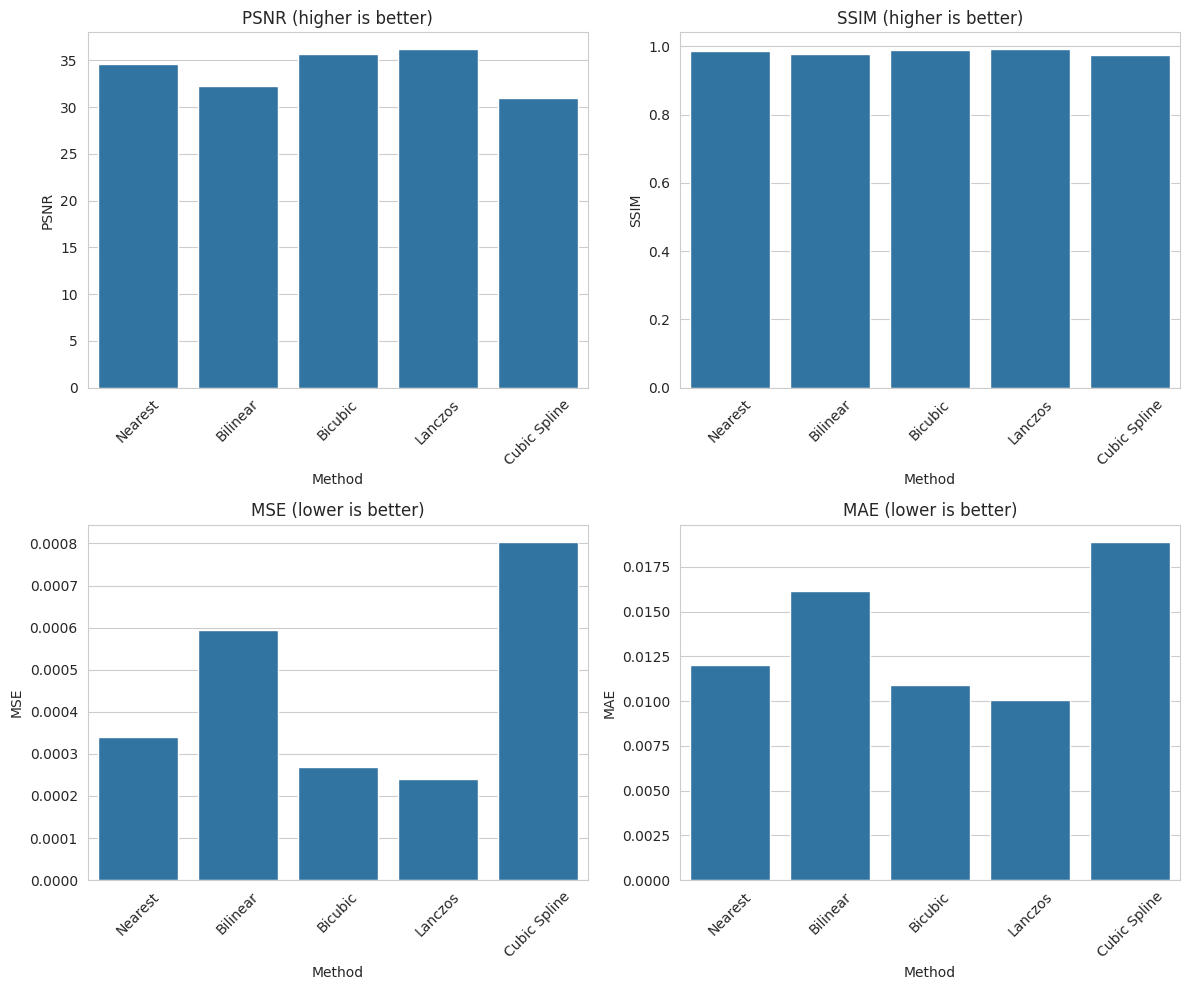

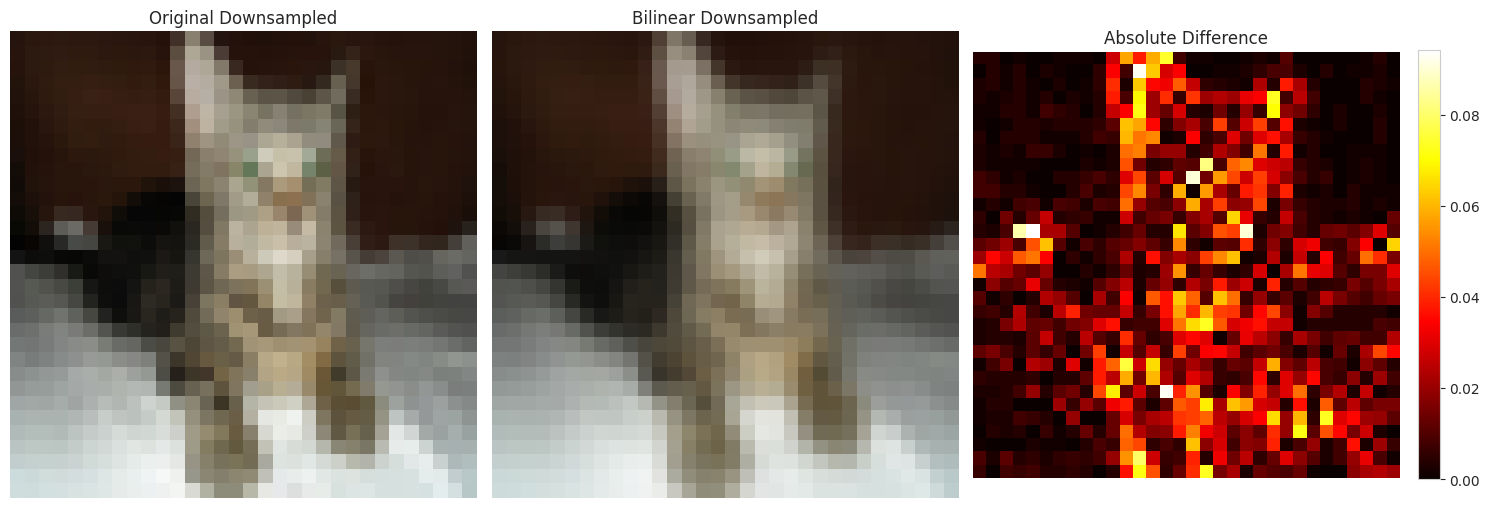

In [46]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define reference image (original downsampled)
reference = downsampled[0]

# Initialize dict to store metrics
metrics = {
    'Method': titles[1:],  # Skip 'Original'
    'MSE': [],
    'PSNR': [],
    'SSIM': [],
    'MAE': [],
    'Correlation': [],
    'Mean Diff': [],
    'Std Diff': []
}

# Calculate metrics for each method compared to reference
for i in range(1, len(downsampled)):
    img = downsampled[i]
    
    # Mean Squared Error
    metrics['MSE'].append(mse(reference, img))
    
    # Peak Signal to Noise Ratio
    metrics['PSNR'].append(psnr(reference, img, data_range=1.0))
    
    # Structural Similarity Index
    if len(reference.shape) == 3:  # RGB image
        ss = ssim(reference, img, data_range=1.0, channel_axis=2)
    else:  # Grayscale
        ss = ssim(reference, img, data_range=1.0)
    metrics['SSIM'].append(ss)
    
    # Mean Absolute Error
    metrics['MAE'].append(np.mean(np.abs(reference - img)))
    
    # Pearson correlation
    if len(reference.shape) == 3:  # RGB image
        # Calculate correlation for each channel and take mean
        corrs = []
        for c in range(reference.shape[2]):
            corr, _ = pearsonr(reference[:,:,c].flatten(), img[:,:,c].flatten())
            corrs.append(corr)
        metrics['Correlation'].append(np.mean(corrs))
    else:
        corr, _ = pearsonr(reference.flatten(), img.flatten())
        metrics['Correlation'].append(corr)
    
    # Mean pixel difference
    metrics['Mean Diff'].append(np.abs(np.mean(reference) - np.mean(img)))
    
    # Standard deviation difference
    metrics['Std Diff'].append(np.abs(np.std(reference) - np.std(img)))

# Create DataFrame
df = pd.DataFrame(metrics)

# Display metrics table
print(df)

# Plot metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot PSNR (higher is better)
sns.barplot(x='Method', y='PSNR', data=df, ax=axes[0,0])
axes[0,0].set_title('PSNR (higher is better)')
axes[0,0].tick_params(axis='x', rotation=45)

# Plot SSIM (higher is better)
sns.barplot(x='Method', y='SSIM', data=df, ax=axes[0,1])
axes[0,1].set_title('SSIM (higher is better)')
axes[0,1].tick_params(axis='x', rotation=45)

# Plot MSE (lower is better)
sns.barplot(x='Method', y='MSE', data=df, ax=axes[1,0])
axes[1,0].set_title('MSE (lower is better)')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot MAE (lower is better)
sns.barplot(x='Method', y='MAE', data=df, ax=axes[1,1])
axes[1,1].set_title('MAE (lower is better)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Heatmap of pixel differences
def plot_diff_heatmaps(method_idx=1):
    method_name = titles[method_idx]
    img = downsampled[method_idx]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(reference)
    plt.title('Original Downsampled')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(img)
    plt.title(f'{method_name} Downsampled')
    plt.axis('off')
    
    plt.subplot(133)
    diff = np.abs(reference - img)
    if len(diff.shape) == 3:
        # Convert RGB difference to grayscale for visualization
        diff = np.mean(diff, axis=2)
    plt.imshow(diff, cmap='hot')
    plt.title(f'Absolute Difference')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show difference heatmap for Bilinear method (index 2)
plot_diff_heatmaps(2)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
from scipy.ndimage import zoom
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm  # Progress bar for notebooks

# Limit to a reasonable number to avoid memory issues
max_cat_images = 50000  # Adjust based on your memory constraints
cat_images = original_cat_images[:max_cat_images]

# Function to process a single image with all upscaling methods
def process_image(image):
    # Convert tensor to numpy if needed
    if hasattr(image, 'numpy'):
        image = image.numpy().transpose(1, 2, 0)  # CHW to HWC
    
    # Ensure values are normalized to 0-1
    if image.max() > 1.0:
        image = image / 255.0
        
    # Convert to uint8 for OpenCV operations
    image_uint8 = (image * 255).astype(np.uint8)
    
    # Target size for upscaling
    target_size = (512, 512)
    
    # Apply different upscaling methods
    nearest = resize(image, target_size, order=0, anti_aliasing=False)
    bilinear = resize(image, target_size, order=1, anti_aliasing=False)
    bicubic = resize(image, target_size, order=3, anti_aliasing=False)
    
    # Lanczos (OpenCV)
    if len(image_uint8.shape) == 3:
        lanczos = cv2.resize(image_uint8, target_size, interpolation=cv2.INTER_LANCZOS4)
        lanczos = lanczos.astype(float) / 255.0
    else:
        lanczos = cv2.resize(image_uint8, target_size, interpolation=cv2.INTER_LANCZOS4)
        lanczos = lanczos.astype(float) / 255.0
    
    # Cubic spline (SciPy)
    zoom_factors = [target_size[0]/image.shape[0], target_size[1]/image.shape[1]]
    if len(image.shape) == 3:
        zoom_factors.append(1)
    spline = zoom(image, zoom_factors, order=3)
    
    # List of all upscaled images
    images = [image, nearest, bilinear, bicubic, lanczos, spline]
    
    # Downsample each image to 32x32 using PIL
    downsampled = []
    for img in images:
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        pil_img_resized = pil_img.resize((32, 32), Image.BILINEAR)
        down_img = np.array(pil_img_resized).astype(float) / 255.0
        downsampled.append(down_img)
    
    return downsampled

# Calculate metrics for one set of downsampled images
def calculate_metrics(downsampled_set):
    reference = downsampled_set[0]  # Original downsampled
    image_metrics = {
        'MSE': [],
        'PSNR': [],
        'SSIM': [], 
        'MAE': [],
        'Correlation': []
    }
    
    for i in range(1, len(downsampled_set)):
        img = downsampled_set[i]
        
        # Calculate metrics
        image_metrics['MSE'].append(mse(reference, img))
        image_metrics['PSNR'].append(psnr(reference, img, data_range=1.0))
        
        if len(reference.shape) == 3:  # RGB image
            image_metrics['SSIM'].append(ssim(reference, img, data_range=1.0, channel_axis=2))
        else:  # Grayscale
            image_metrics['SSIM'].append(ssim(reference, img, data_range=1.0))
            
        image_metrics['MAE'].append(np.mean(np.abs(reference - img)))
        
        # Correlation
        if len(reference.shape) == 3:
            corrs = []
            for c in range(reference.shape[2]):
                corr, _ = pearsonr(reference[:,:,c].flatten(), img[:,:,c].flatten())
                corrs.append(corr)
            image_metrics['Correlation'].append(np.mean(corrs))
        else:
            corr, _ = pearsonr(reference.flatten(), img.flatten())
            image_metrics['Correlation'].append(corr)
            
    return image_metrics

# Process all selected cat images
all_metrics = {
    'MSE': [],
    'PSNR': [],
    'SSIM': [],
    'MAE': [],
    'Correlation': []
}

# Process each image and collect metrics
print(f"Processing {len(cat_images)} cat images...")
for img in tqdm(cat_images):
    downsampled_set = process_image(img)
    metrics = calculate_metrics(downsampled_set)
    
    for key in all_metrics:
        all_metrics[key].append(metrics[key])

# Convert lists of lists to numpy arrays for easier analysis
for key in all_metrics:
    all_metrics[key] = np.array(all_metrics[key])

# Calculate average metrics
avg_metrics = {
    'Method': ['Nearest', 'Bilinear', 'Bicubic', 'Lanczos', 'Cubic Spline']
}

for key in all_metrics:
    avg_metrics[key] = np.mean(all_metrics[key], axis=0)

# Create DataFrame for the average metrics
df_avg = pd.DataFrame(avg_metrics)
print("\nAverage Metrics Across All Cat Images:")
print(df_avg)

# Plot average metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.barplot(x='Method', y='PSNR', data=df_avg, ax=axes[0,0])
axes[0,0].set_title('PSNR (higher is better)')
axes[0,0].tick_params(axis='x', rotation=45)

sns.barplot(x='Method', y='SSIM', data=df_avg, ax=axes[0,1])
axes[0,1].set_title('SSIM (higher is better)')
axes[0,1].tick_params(axis='x', rotation=45)

sns.barplot(x='Method', y='MSE', data=df_avg, ax=axes[1,0])
axes[1,0].set_title('MSE (lower is better)')
axes[1,0].tick_params(axis='x', rotation=45)

sns.barplot(x='Method', y='MAE', data=df_avg, ax=axes[1,1])
axes[1,1].set_title('MAE (lower is better)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Create violin plots to show distributions across all images
metric_data = {'Method': [], 'PSNR': [], 'SSIM': [], 'MSE': [], 'MAE': []}
methods = ['Nearest', 'Bilinear', 'Bicubic', 'Lanczos', 'Cubic Spline']

for m_idx, method in enumerate(methods):
    for i in range(len(cat_images)):
        metric_data['Method'].append(method)
        metric_data['PSNR'].append(all_metrics['PSNR'][i, m_idx])
        metric_data['SSIM'].append(all_metrics['SSIM'][i, m_idx])
        metric_data['MSE'].append(all_metrics['MSE'][i, m_idx])
        metric_data['MAE'].append(all_metrics['MAE'][i, m_idx])

df_dist = pd.DataFrame(metric_data)

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.violinplot(x='Method', y='PSNR', data=df_dist, ax=axes[0,0])
axes[0,0].set_title('PSNR Distribution')
axes[0,0].tick_params(axis='x', rotation=45)

sns.violinplot(x='Method', y='SSIM', data=df_dist, ax=axes[0,1])
axes[0,1].set_title('SSIM Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

sns.violinplot(x='Method', y='MSE', data=df_dist, ax=axes[1,0])
axes[1,0].set_title('MSE Distribution')
axes[1,0].tick_params(axis='x', rotation=45)

sns.violinplot(x='Method', y='MAE', data=df_dist, ax=axes[1,1])
axes[1,1].set_title('MAE Distribution')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Processing 5000 cat images...


  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [142]:
# %%
import clip
import torch

# Check for device and load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, clip_preprocess = clip.load("ViT-B/32", device=device)
print(f"Using device: {device}")

# Compute CLIP embeddings for each synthetic image
clip_embeddings = []
valid_synthetic_files = []  # Store successfully processed synthetic image paths

for file_path in synthetic_image_files:
    try:
        image = Image.open(file_path).convert("RGB")
        image_input = clip_preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model.encode_image(image_input)
            # Normalize to unit length (so cosine similarity equals dot product)
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)
            clip_embeddings.append(embedding.cpu().numpy()[0])
            valid_synthetic_files.append(file_path)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Compute CLIP embeddings for 50 original images
clip_for_50_original_images = []
valid_original_files = []  # Store successfully processed original images

to_pil = transforms.ToPILImage()

for img in original_cat_images[:50]:
    try:
        img_pil = to_pil(img)
        image_input = clip_preprocess(img_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model.encode_image(image_input)
            # Normalize to unit length
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)
            clip_for_50_original_images.append(embedding.cpu().numpy()[0])
            valid_original_files.append(img)  # Storing image tensor instead of file path
    except Exception as e:
        print("Error processing an original image:", e)

# Convert to NumPy arrays
clip_embeddings = np.array(clip_embeddings)
clip_for_50_original_images = np.array(clip_for_50_original_images)

print(f"Computed CLIP embeddings for {clip_embeddings.shape[0]} synthetic images.")
print(f"Computed CLIP embeddings for {clip_for_50_original_images.shape[0]} original images.")

# %%
# Randomly select 50 reference images from valid original images
num_refs = min(50, len(clip_for_50_original_images))  # Handle cases where fewer than 50 exist
ref_indices = np.random.choice(len(clip_for_50_original_images), size=num_refs, replace=False)
ref_embeddings = clip_for_50_original_images[ref_indices]

ref_from_synthetics_indeces = np.random.choice(len(clip_embeddings), size=num_refs, replace=False)
ref_from_synthetics = clip_embeddings[ref_from_synthetics_indeces]

# Compute the average cosine similarity of each synthetic image with the reference embeddings
# (Since all embeddings are normalized, cosine similarity is just the dot product.)
similarity_scores = np.dot(clip_embeddings, ref_embeddings.T).mean(axis=1)
similarity_scores_ref_synth = np.dot(clip_embeddings, ref_from_synthetics.T).mean(axis=1)

print(f"Similarity scores: min={similarity_scores.min():.4f}, max={similarity_scores.max():.4f}, mean={similarity_scores.mean():.4f}")
print(f"Similarity scores for synthetic references: min={similarity_scores_ref_synth.min():.4f}, max={similarity_scores_ref_synth.max():.4f}, mean={similarity_scores_ref_synth.mean():.4f}")


Using device: cuda
Computed CLIP embeddings for 1173 synthetic images.
Computed CLIP embeddings for 50 original images.
Similarity scores: min=0.5000, max=0.8296, mean=0.7339
Similarity scores for synthetic references: min=0.4797, max=0.8862, mean=0.8271


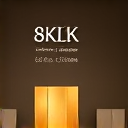

'Similarity: 0.5000'

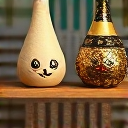

'Similarity: 0.5713'

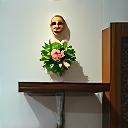

'Similarity: 0.5776'

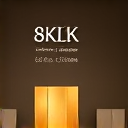

'Similarity: 0.4797'

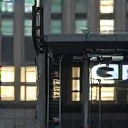

'Similarity: 0.5381'

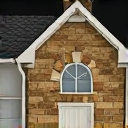

'Similarity: 0.5562'

In [145]:
# display the images with the highest and lowest similarity scores
def display_images(image_paths, similarity_scores, num_images=5, ascending=True):
    indices = np.argsort(similarity_scores)
    if not ascending:
        indices = indices[::-1]
    for i in range(num_images):
        idx = indices[i]
        score = similarity_scores[idx]
        path = image_paths[idx]
        img = Image.open(path)
        display(img, f"Similarity: {score:.4f}")

# Display images with the highest similarity scores
display_images(valid_synthetic_files, similarity_scores, num_images=3, ascending=True)
display_images(valid_synthetic_files, similarity_scores_ref_synth, num_images=3, ascending=True)

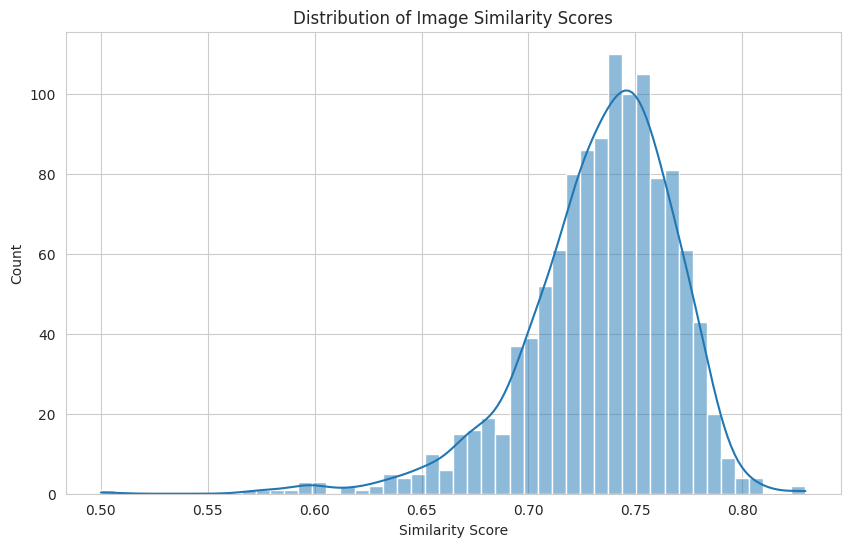

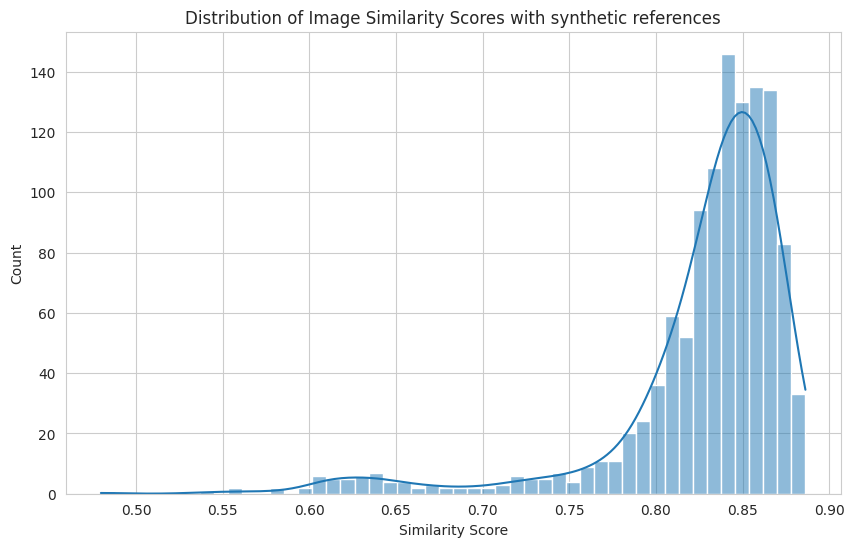

In [146]:
#plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores, bins=50, kde=True)
plt.title("Distribution of Image Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.show()

#plot the distribution of similarity scores
plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores_ref_synth, bins=50, kde=True)
plt.title("Distribution of Image Similarity Scores with synthetic references")
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.show()

Explained variance ratio by PCA components: [0.12577208 0.07259665]


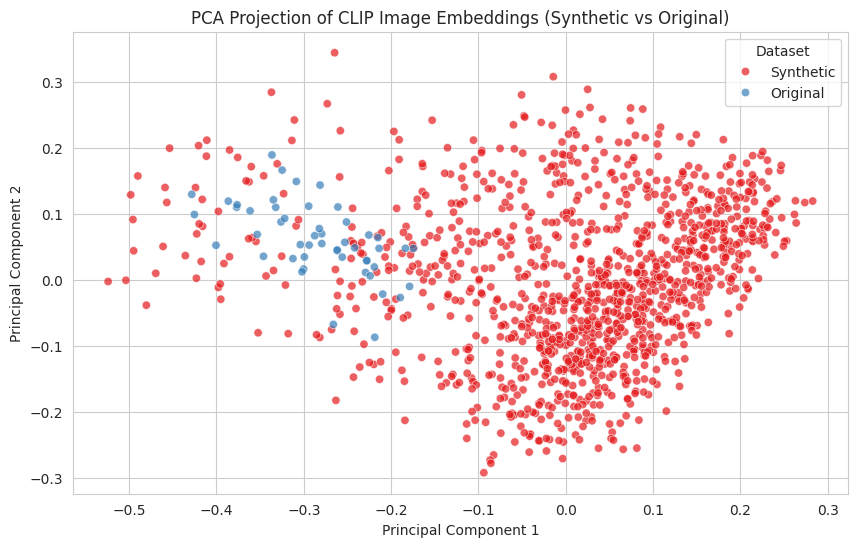

In [147]:
# Combine synthetic and original CLIP embeddings
all_embeddings = np.concatenate([clip_embeddings, clip_for_50_original_images], axis=0)
labels = ["Synthetic"] * len(clip_embeddings) + ["Original"] * len(clip_for_50_original_images)

# Perform PCA
pca = PCA(n_components=2)
all_clip_pca = pca.fit_transform(all_embeddings)
print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)

# Create a DataFrame for visualization
df_all_clip_pca = pd.DataFrame({
    "PC1": all_clip_pca[:, 0],
    "PC2": all_clip_pca[:, 1],
    "Dataset": labels
})

# Plot the PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_all_clip_pca, x="PC1", y="PC2", hue="Dataset", alpha=0.7, palette="Set1")
plt.title("PCA Projection of CLIP Image Embeddings (Synthetic vs Original)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Dataset")
plt.show()